Содержание<span class="tocSkip"></span></h1> 
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Импорт-библиотек" data-toc-modified-id="Импорт-библиотек-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Импорт библиотек</a></span></li><li><span><a href="#Загрузка-и-подготовка-данных" data-toc-modified-id="Загрузка-и-подготовка-данных-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Загрузка и подготовка данных</a></span></li><li><span><a href="#Изучение-и--подготовка-данных" data-toc-modified-id="Изучение-и--подготовка-данных-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Изучение и  подготовка данных</a></span></li></ul></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Деление-данных-на-выборки" data-toc-modified-id="Деление-данных-на-выборки-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Деление данных на выборки</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания. 
 
Значение метрики *RMSE* на тестовой выборке должно быть не больше 48. 
 
Вам нужно: 
 
1. Загрузить данные и выполнить их ресемплирование по одному часу. 
2. Проанализировать данные. 
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных. 
4. Проверить данные на тестовой выборке и сделать выводы. 
 
 
Данные лежат в файле taxi.csv. Количество заказов находится в столбце num_orders (от англ. *number of orders*, «число заказов»).

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

In [2]:
df = pd.read_csv('https://code.s3.yandex.net/datasets/taxi.csv',index_col=[0], parse_dates=[0])

In [3]:
df

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [5]:
df.sort_index(inplace=True)

In [6]:
df.index.is_monotonic


True

In [7]:

df = df.resample('1H').sum()


<AxesSubplot:xlabel='datetime'>

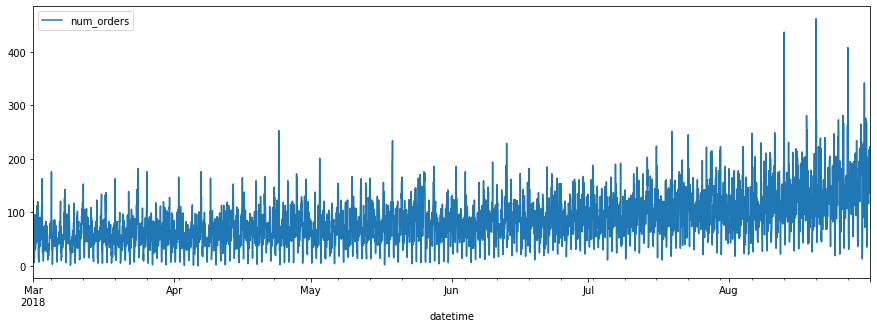

In [8]:
df.plot(figsize=(15,5))

In [9]:
decomposed =seasonal_decompose(df)

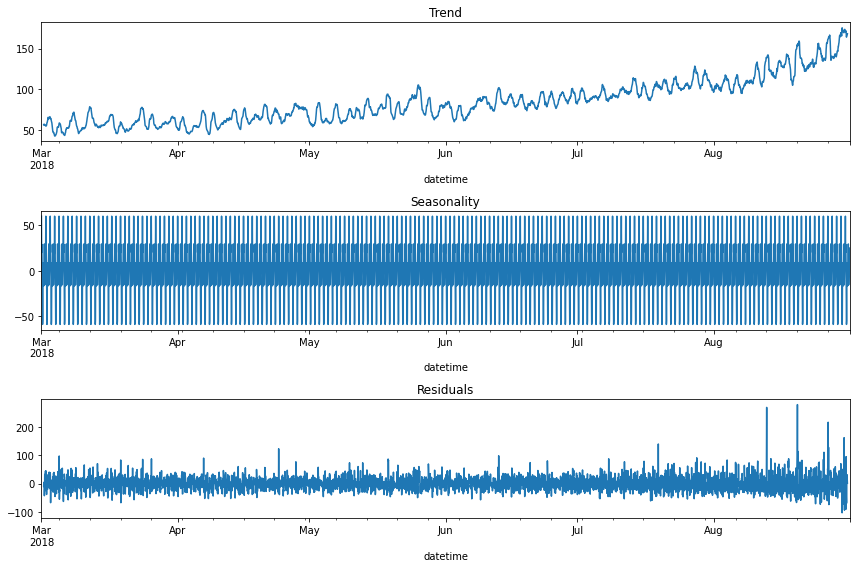

In [10]:
plt.figure(figsize=(12, 8))
plt.subplot(311)

decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()


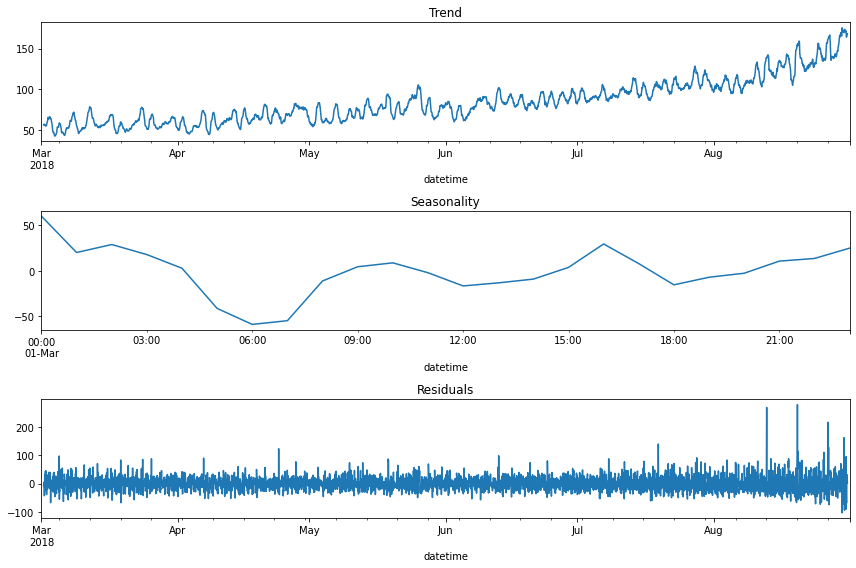

In [11]:
plt.figure(figsize=(12, 8))
plt.subplot(311)

decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal['2018-03-01':'2018-03-01'].plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()


In [12]:
def make_features(df, max_lag, rolling_mean_size):
    df['day'] = df.index.day
    df['dayofweek'] = df.index.dayofweek
    df['hour'] = df.index.hour
    
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)

    df['rolling_mean'] = df['num_orders'].shift().rolling(4).mean()

In [59]:
make_features(df,50,24)

In [60]:
train,test=train_test_split(df,test_size=0.1,shuffle = False)
train = train.dropna()

In [61]:
features_train  = train.drop('num_orders', axis=1)
target_train = train[['num_orders']]

features_test = test.drop('num_orders', axis=1)
target_test = test[['num_orders']]

In [62]:
#scaler = StandardScaler()
#scaler.fit(features_train)
#
#features_train = scaler.transform(features_train)
#features_test = scaler.transform(features_test)

####  LinearRegression

In [65]:
model_lin = LinearRegression()

print(f'''Значение метрики RMSE на обучающей выборке для LinearRegression''', cross_val_score(model_lin,features_train,target_train, 
                         cv = TimeSeriesSplit(n_splits=8), 
                         n_jobs = -1, 
                         scoring = 'neg_root_mean_squared_error').mean())

Значение метрики RMSE на обучающей выборке для LinearRegression -24.352681157058697


In [66]:
greed = -32.25933595561962

#### DecisionTreeRegressor

In [67]:
model_tree = RandomForestRegressor(random_state=12345)

In [68]:
parameters = {"max_depth" : range(15,20)}

greed1 = GridSearchCV(model_tree, param_grid=parameters,scoring='neg_root_mean_squared_error', 
                   cv=TimeSeriesSplit(n_splits=8))

In [69]:
greed1.fit(features_train,np.ravel(target_train))

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=8, test_size=None),
             estimator=RandomForestRegressor(random_state=12345),
             param_grid={'max_depth': range(15, 20)},
             scoring='neg_root_mean_squared_error')

In [70]:
greed1.best_score_

-23.767340759444934

#### CatBoost

In [71]:
cat = CatBoostRegressor(random_state = 12345,loss_function='RMSE',iterations=500,verbose=100) 

In [72]:
parameters = {"max_depth" : range(2,5)}

greed2 = GridSearchCV(cat, param_grid=parameters,scoring='neg_root_mean_squared_error', 
                   cv=TimeSeriesSplit(n_splits=8))

In [73]:
greed2.fit(features_train,target_train)

Learning rate set to 0.063089
0:	learn: 27.6195886	total: 2.47ms	remaining: 1.23s
100:	learn: 15.9905075	total: 44.6ms	remaining: 176ms
200:	learn: 13.4223069	total: 78.1ms	remaining: 116ms
300:	learn: 11.9159004	total: 112ms	remaining: 74.1ms
400:	learn: 10.6038826	total: 147ms	remaining: 36.4ms
499:	learn: 9.6244121	total: 179ms	remaining: 0us
Learning rate set to 0.070391
0:	learn: 28.2987168	total: 1.06ms	remaining: 532ms
100:	learn: 17.1340242	total: 41.3ms	remaining: 163ms
200:	learn: 15.2578447	total: 82.5ms	remaining: 123ms
300:	learn: 14.0011773	total: 126ms	remaining: 83ms
400:	learn: 13.0949803	total: 170ms	remaining: 41.9ms
499:	learn: 12.3383440	total: 210ms	remaining: 0us
Learning rate set to 0.075048
0:	learn: 29.4897417	total: 483us	remaining: 242ms
100:	learn: 18.1170282	total: 46.3ms	remaining: 183ms
200:	learn: 16.5844944	total: 93.9ms	remaining: 140ms
300:	learn: 15.5374026	total: 142ms	remaining: 94.1ms
400:	learn: 14.6802017	total: 190ms	remaining: 46.9ms
499:	lea

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=8, test_size=None),
             estimator=<catboost.core.CatBoostRegressor object at 0x13e850550>,
             param_grid={'max_depth': range(2, 5)},
             scoring='neg_root_mean_squared_error')

In [74]:
greed2.best_score_

-23.34162995183746

#### LightGBM

In [75]:
model = LGBMRegressor()

In [76]:
parameters = parameters = {
              'max_depth': range (15,20),
              }

greed3 = GridSearchCV(model, param_grid=parameters,scoring='neg_root_mean_squared_error', 
                   cv=TimeSeriesSplit(n_splits=8))

In [77]:
greed3.fit(features_train,np.ravel(target_train))

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=8, test_size=None),
             estimator=LGBMRegressor(), param_grid={'max_depth': range(15, 20)},
             scoring='neg_root_mean_squared_error')

In [78]:
greed3.best_score_

-23.468440020816445

In [79]:
data = pd.DataFrame([['LinearRegression',greed ],
                  ['DecisionTreeRegressor',greed1.best_score_],
                  ['CatBoost',greed2.best_score_],
                  ['LightGBM',greed3.best_score_]], 
columns=['Model','RMSE',])
print(data)

                   Model       RMSE
0       LinearRegression -32.259336
1  DecisionTreeRegressor -23.767341
2               CatBoost -23.341630
3               LightGBM -23.468440


### Тестирование лучшей модели 

In [80]:

predictions = greed1.predict(features_test) 
result = mean_squared_error(target_test, predictions) ** 0.5
print(result)

43.05526799038655


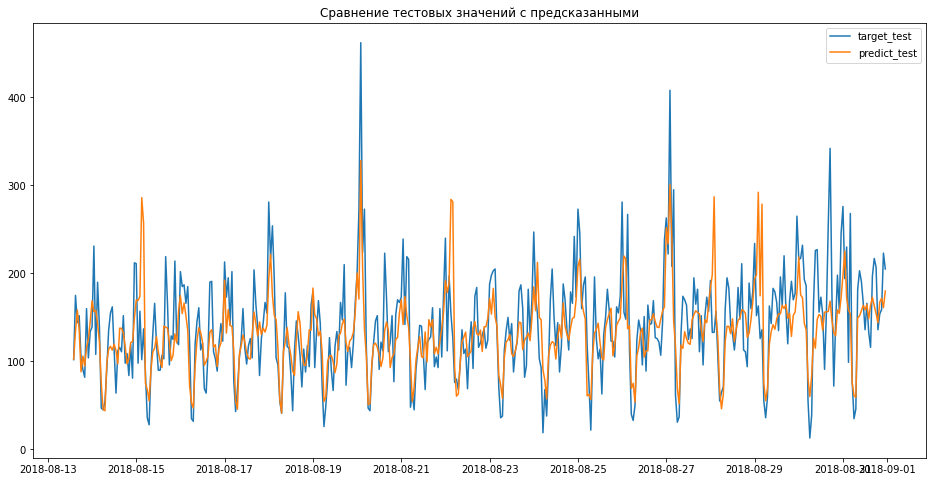

In [81]:
plt.figure(figsize=(16, 8))

plt.plot(target_test, label='target_test')
plt.plot(target_test.index, predictions, label='predict_test')

plt.title('Сравнение тестовых значений с предсказанными')
plt.legend()
plt.show()